In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
from operators.setup_FOM_two_stream import SimulationSetupTwoStreamFOM
from operators.FOM import total_mass, total_momentum, total_energy_k, psi_ln_aw
import scipy

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Two stream instability singular value decomposition

In [4]:
setup = SimulationSetupTwoStreamFOM(Nx=251,
                                    Nv=350,
                                    epsilon=0.1,
                                    alpha_e1=0.5,
                                    alpha_e2=0.5,
                                    alpha_i=np.sqrt(2 / 1836),
                                    u_e1=-1.05,
                                    u_e2=1.05,
                                    u_i=0,
                                    L=2 * np.pi,
                                    dt=1e-2,
                                    T0=0,
                                    T=40,
                                    nu_e1=15,
                                    nu_e2=15,
                                    n0_e1=0.5,
                                    n0_e2=0.5,
                                    construct_B=False)

In [5]:
# velocity grid for plotting purposes
v = np.linspace(-4, 4, int(10**4))
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)

In [6]:
# number of moments to solve for M
M = 7

In [7]:
u_train = [1.05, 1.06, 1.07, 1.08]

In [8]:
# basis save first 1000 modes (we dont really use more than that)
Ur_e1 = np.load("../data/ROM/two_stream/basis_SVD_e1_" + str(setup.T0) + "_" + str(setup.T) + "_M_" + str(M) + ".npy")
Ur_e2 = np.load("../data/ROM/two_stream/basis_SVD_e2_" + str(setup.T0) + "_" + str(setup.T) + "_M_" + str(M) + ".npy")

In [9]:
# singular values
S_e1 = np.load("../data/ROM/two_stream/singular_values_SVD_e1_" + str(setup.T0) + "_" + str(setup.T) + "_M_" + str(M) + ".npy")
S_e2 = np.load("../data/ROM/two_stream/singular_values_SVD_e2_" + str(setup.T0) + "_" + str(setup.T) + "_M_" + str(M) + ".npy")

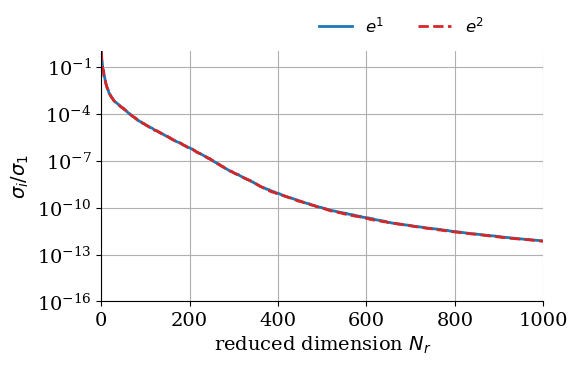

In [10]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(len(S_e1)), (np.abs(S_e1)/np.max(S_e1[0])), color="tab:blue",linewidth=2, label=r"$e^{1}$")
ax.plot(np.arange(len(S_e2)), (np.abs(S_e2)/np.max(S_e2[0])), ls="--", color="tab:red", linewidth=2, label=r"$e^{2}$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\sigma_{i}/\sigma_{1}$")
ax.set_xlabel(r"reduced dimension $N_{r}$")
ax.set_yscale("log")
ax.set_ylim(10**-16, 1)
ax.set_xlim(0, 1000)
plt.grid()

legend = ax.legend(ncols=3, fancybox=False, shadow=False, fontsize=12, loc='upper right', bbox_to_anchor=(0.9, 1.2))
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/singular_value_decay_linear_landau_M" + str(M) + ".png", dpi=300, bbox_inches='tight')

In [47]:
U_e1_tensor = np.zeros((setup.Nv - M, setup.Nx, np.shape(Ur_e1)[-1]))
U_e2_tensor = np.zeros((setup.Nv - M, setup.Nx, np.shape(Ur_e2)[-1]))

for n in range(0, setup.Nv - M):
    U_e1_tensor[n, :, :] = Ur_e1[n*setup.Nx: (n+1)*setup.Nx, :]
    U_e2_tensor[n, :, :] = Ur_e2[n*setup.Nx: (n+1)*setup.Nx, :]

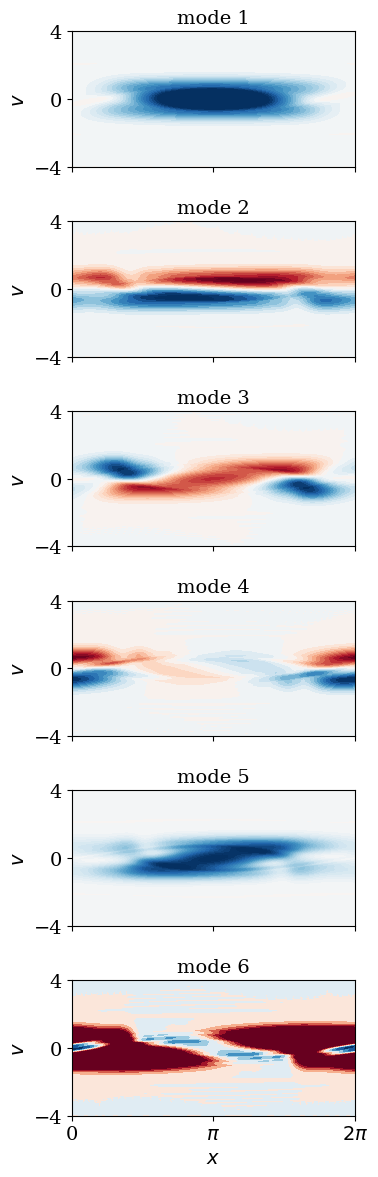

In [14]:
# plot phase space evolution 
fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(4, 12))
for tt, ii in enumerate([0, 1, 2, 3, 4, 5]):
    distribution1 = np.zeros((setup.Nx + 1, len(v)))
    distribution2 = np.zeros((setup.Nx + 1, len(v)))
    for jj in range(setup.Nv - M):
        distribution1 += np.outer(np.append(U_e1_tensor[jj, :, ii], U_e1_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e1, alpha_s=setup.alpha_e1, v=v, n=jj))
        distribution2 += np.outer(np.append(U_e2_tensor[jj, :, ii], U_e2_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e2, alpha_s=setup.alpha_e2, v=v, n=jj))
    pos = ax[tt].contourf(x, v, (distribution1 + distribution2).T, cmap="RdBu", vmax=np.max(distribution1), vmin=-np.max(distribution1), levels=30)
    ax[tt].set_ylabel("$v$")
    ax[tt].set_yticks([-4, 0, 4])
    ax[tt].set_title("mode " + str(ii + 1), fontsize=14)
    
_ = ax[-1].set_xlabel("$x$")
_ = ax[-1].set_xticks([0, np.pi, 2*np.pi])
_ = ax[-1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/POD_modes_1_M" + str(M) + ".png", dpi=200, bbox_inches='tight')

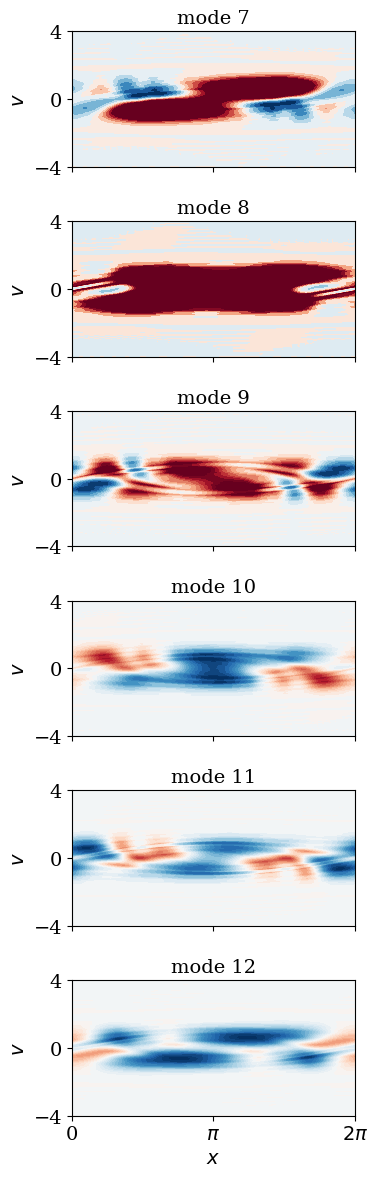

In [15]:
# plot phase space evolution 
fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(4, 12))
for tt, ii in enumerate([6, 7, 8, 9, 10, 11]):
    distribution1 = np.zeros((setup.Nx + 1, len(v)))
    distribution2 = np.zeros((setup.Nx + 1, len(v)))
    for jj in range(setup.Nv - M):
        distribution1 += np.outer(np.append(U_e1_tensor[jj, :, ii], U_e1_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e1, alpha_s=setup.alpha_e1, v=v, n=jj))
        distribution2 += np.outer(np.append(U_e2_tensor[jj, :, ii], U_e2_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e2, alpha_s=setup.alpha_e2, v=v, n=jj))
    pos = ax[tt].contourf(x, v, (distribution1 + distribution2).T, cmap="RdBu", vmax=np.max(distribution1), vmin=-np.max(distribution1), levels=30)
    ax[tt].set_ylabel("$v$")
    ax[tt].set_yticks([-4, 0, 4])
    ax[tt].set_title("mode " + str(ii + 1), fontsize=14)
    
_ = ax[-1].set_xlabel("$x$")
_ = ax[-1].set_xticks([0, np.pi, 2*np.pi])
_ = ax[-1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/POD_modes_2_M" + str(M) + ".png", dpi=200, bbox_inches='tight')

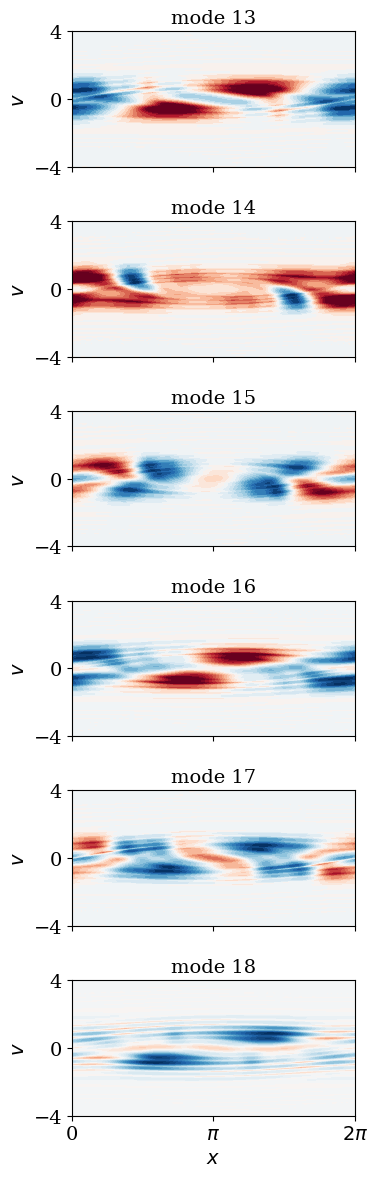

In [16]:
# plot phase space evolution 
fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(4, 12))
for tt, ii in enumerate([12, 13, 14, 15, 16, 17]):
    distribution1 = np.zeros((setup.Nx + 1, len(v)))
    distribution2 = np.zeros((setup.Nx + 1, len(v)))
    for jj in range(setup.Nv - M):
        distribution1 += np.outer(np.append(U_e1_tensor[jj, :, ii], U_e1_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e1, alpha_s=setup.alpha_e1, v=v, n=jj))
        distribution2 += np.outer(np.append(U_e2_tensor[jj, :, ii], U_e2_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e2, alpha_s=setup.alpha_e2, v=v, n=jj))
    pos = ax[tt].contourf(x, v, (distribution1 + distribution2).T, cmap="RdBu", vmax=np.max(distribution1), vmin=-np.max(distribution1), levels=30)
    ax[tt].set_ylabel("$v$")
    ax[tt].set_yticks([-4, 0, 4])
    ax[tt].set_title("mode " + str(ii + 1), fontsize=14)
    
_ = ax[-1].set_xlabel("$x$")
_ = ax[-1].set_xticks([0, np.pi, 2*np.pi])
_ = ax[-1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/POD_modes_3_M" + str(M) + ".png", dpi=200, bbox_inches='tight')

## Projection error

In [39]:
# load the simulation results
sol_test = np.load("../data/FOM/two_stream/sample_1.065/sol_FOM_u_350_nu_15_0_40.npy")[:, ::1000]

In [40]:
Nr = 100

In [ ]:
E_e1 = Ur_e1[:, :Nr].T @ sol_test[M*setup.Nx: setup.N, :]

In [ ]:
E_e2 = Ur_e2[:, :Nr].T @ sol_test[M*setup.Nx + setup.N:, :]

In [ ]:
reconstructed_e1 = Ur_e1[:, :Nr] @ E_e1 

In [ ]:
reconstructed_e2 = Ur_e2[:, :Nr] @ E_e2

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
moment = 10

# Choose a colormap
cmap = plt.get_cmap('viridis')
# Get an array of colors from the colormap
colors = cmap(np.linspace(0, 1, int(sol_test.shape[1] + 1))) 

for ii in range(sol_test.shape[1]):
    plt.plot(x[:-1], sol_test[(moment)*setup.Nx:(moment+1)*setup.Nx,ii], c=colors[ii], alpha=0.5, label="t = " + str(ii*10))
    plt.plot(x[:-1], reconstructed_e1[(moment-M)*setup.Nx:(moment-M+1)*setup.Nx, ii], linewidth=2,ls="--", color=colors[ii])    

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid()
legend = ax.legend(ncols=3, fancybox=False, shadow=False, fontsize=12, loc='upper right', bbox_to_anchor=(0.9, 1.25))
legend.get_frame().set_alpha(0)
_ = ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_xlim(0, 2*np.pi)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
moment = 8
# Choose a colormap
cmap = plt.get_cmap('viridis')
# Get an array of colors from the colormap
colors = cmap(np.linspace(0, 1, int(sol_test.shape[1] + 1))) 

for ii in range(sol_test.shape[1]):
    plt.plot(x[:-1], sol_test[setup.Nx*setup.Nv + moment*setup.Nx: setup.Nx*setup.Nv + (moment+ 1)*setup.Nx,ii], alpha=0.5, c=colors[ii], label="t = " + str(ii*10))
    plt.plot(x[:-1], reconstructed_e2[(moment-M)*setup.Nx:(moment-M+1)*setup.Nx, ii], linewidth=2,ls="--", color=colors[ii])   

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid()
legend = ax.legend(ncols=3, fancybox=False, shadow=False, fontsize=12, loc='upper right', bbox_to_anchor=(0.9, 1.25))
legend.get_frame().set_alpha(0)
_ = ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_xlim(0, 2*np.pi)
plt.tight_layout()

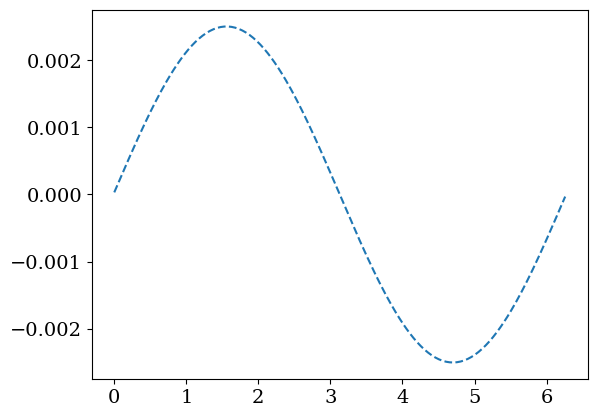

In [33]:
plt.plot(x[:-1], sol_test[setup.Nx*setup.Nv: setup.Nx*setup.Nv + setup.Nx,0] - np.flip(sol_test[: setup.Nx, 0]), ls="--")

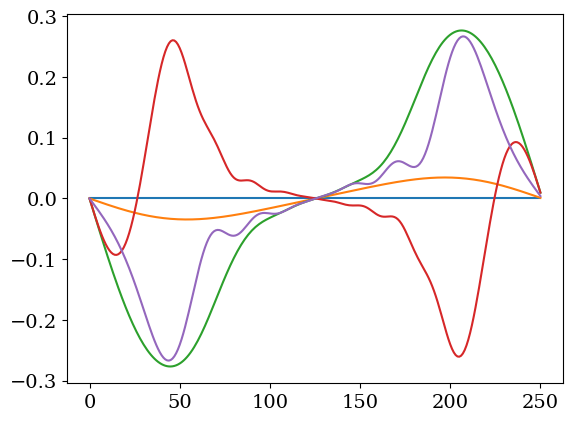

In [36]:
plt.plot(sol_test[setup.N:setup.N+setup.Nx, :] - sol_test[:setup.Nx, :])